# MNIST with vanilla Convolutional Neural Network using Tensorflow

In the previous notebook we built a simple 4-layer vanilla NN with MNIST. We saw, that this simple architecture achieved over 95% accuracy on the test dataset without much tunning (or any whatsoever). Thus, using Convolutional Neural Networks we should achive higher accuracy without much more effort. Then, we tried using CIFAR with basically the same simple architecture, achieving ~48% accuracy with 20 epochs, not so succesful.
In this notebook, we will follow two different approaches to train a CNN with CIFAR10 data. First, it will be a simpler network with low level tensorflow using tf.gradients. Then, we will improve our model using tf.keras.conv2d layers, which will take care of updating parameters for us.

In [1]:
# Import all the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

## Importing and preprocessing the data
We will use the CIFAR10 dataset, which we will download from Alex Krizhevsky website at University of Toronto at https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
For more details of the CIFAR10, dataset please refer to https://www.cs.toronto.edu/~kriz/cifar.html or 
Krizhevsky, A., "LearningMultipleLayersofFeaturesfromTinyImages", 2009, https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
Since, here we will only use CIFAR10 dataset, we don't need to load MNIST.
Initially the notebook will follow a very similar style to that previously completed, likewise we will share some functions like the accuracy check and minibatch.

Furthermore, to have a cleaner notebook, we will not include all the sanity checks we used in the previous notebooks, e.g. we will not check all the data types and shapes, since we already did in the previous notebook.

In [2]:
'''
    This functions load CIFAR 10 data (from binary files inside cifar-10-python.tar.gz). Notice that the files 
    have been 'untar-ed' manually into folder specified in path. This is convenient, since it is not ideal to 
    download the data everytime we run the notebook, particularly because CIFAR10 tar file is ~170MB.

    These two functions are based on two function provided in data_utils.py in Stanford CNN for Visual 
    Recognition CS231n in (https://cs231n.github.io/assignments2019/assignment1/), and by Tensorflow cifar10.py as
    in: https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/keras/_impl/keras/datasets/cifar10.py
    and https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/keras/_impl/keras/datasets/cifar.py

     Inputs:
     - path: Path to CIFAR10 'untar-ed' files
     
     Outputs:
     - (x_train, y_train), (x_test, y_test): Two tuples with numpy arrays containing the train and test data 
'''
import os
from six.moves import cPickle as pickle
    
def load_CIFAR10_data(path):
    """ load all of cifar """
    data = []
    labels = []
    for b in range(1,6):
        f = os.path.join(path, 'data_batch_%d' % (b, ))
        x, y = load_CIFAR_batch(f)
        data.append(x)
        labels.append(y)
    x_train = np.concatenate(data)
    y_train = np.concatenate(labels)
    del x, y
    x_test, y_test = load_CIFAR_batch(os.path.join(path, 'test_batch'))
    return (x_train, y_train), (x_test, y_test)

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        # Using encoding 'latin1' prevents errors with objects that may have been pickled with Python2
        d = pickle.load(f, encoding='latin1')    
        data = d['data']
        labels = d['labels']
        data = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1)
        labels = np.array(labels)
        return data, labels


In [3]:
# This command allows downloading the dataset directly
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.cifar10.load_data()

# Otherwise, if the data have been downloaded before, it is possible to specify the path to the data files
# and use the functions provided before
# (x_train, y_train), (x_test, y_test)= load_CIFAR10_data('/home/josh/Documents/cs231n/cifar-10-batches')
# (x_train, y_train), (x_test, y_test)= load_CIFAR10_data('/tf/mydata/s/Documents/cifar-10-batches')

In [4]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
              'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [5]:
# It is a good idea to visualise the data we just loaded.
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Train image shape:  (32, 32, 3)
The image is a:  Frog


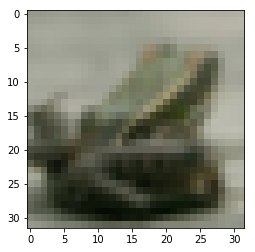

In [6]:
# So, as expected we have 50,000 training images and 10,0000 for testing. What is
# each image shape? Let's find out
print('Train image shape: ', x_train[1].shape)

# We can randomly show any of the numbers
rnd_idx = np.random.randint(x_train.shape[0])
plt.imshow(x_train[rnd_idx].astype(np.int32)) #Using astype guarantess imshow work
print('The image is a: ', classes[y_train[rnd_idx, 0]])

In [7]:
# For simplicity and to use default TF settings, we cast the data to int32 and float32
# Since, the dataset is relatively small, in most cases, this is not a problem
y_train = y_train.astype(np.int32).reshape(-1)
y_test = y_test.astype(np.int32).reshape(-1)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [8]:
# Here we define a function to divide our data in N mini batches, this is an important step, to allow for mini batch 
# gradient descent

def mini_batches(mini_batch_size, data_x, data_y = None):
    # First we validate the data is of the expected type, and the number of labels meet the number of training samples
    assert data_x.shape[0] == data_y.shape[0], 'X number of samples not equal to Y number of samples'
    assert (isinstance(data_x, np.ndarray) and isinstance(data_y, np.ndarray)), 'Data not numpy array'
    
    N = data_x.shape[0] # Get the number of samples
    idxs = np.arange(N) 
    # Shuffle data, this may not be so critical in this example, but it is important for most applications, to avoid
    # strong correlations in mini batches
    np.random.shuffle(idxs)
    data_x = data_x[idxs] # Shuffle training samples
    data_y = data_y[idxs] # Shuffle labels (don't forget)
    
    # Finally return the data in minibatches of the desired size
    # List comprehension is so cool, technically this is returning a generator but the principle is the same
    return ((data_x[i:i+mini_batch_size], data_y[i:i+mini_batch_size]) for i in range(0, N, mini_batch_size))

type(mini_batches(64, x_test, y_test)) # Check type returned by function

generator

## Tensorflow Low Level CNN 
In this part of the notebook, we will implement a complete CNN using Low Level TF only. I.e., we will not use those nice Keras layers. We will use 2D convolutions, with defined weights, which will be updated with tf.gradients (I mean, not that low level after all). 
For this notebokk, we will follow a simple approach where all the filters are 3x3 in size.
We will use 5-layer CNN.


In [9]:
def init_five_layer_CNN(num_filters):
    '''
    This function will be used to initialise all the learnable parameters. For simplicity all the filters
    are size 3x3.
    
    Inputs:
    - num_filters: List containing the number of filters for each layer, including the input (e.g. 3 RGB channels)
      This will have the shape [channels, k1, k2, k3, k4, classes]

    Outputs:
    - Parameters: Dictionary with network parameters, where element 'W1' and 'b1' represent weigth and bias
      for layer one
    '''
    # Dictionary  to save  parameters
    parameters = {}
        
    # Manually assing filter size 
    fsize = 3 
    
    # Number of filters
    c, k1, k2, k3, k4, classes = num_filters

    # For this architecture, we will use the more robust initialization described in:   
    #     He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance 
    #     on ImageNet Classification, ICCV 2015, https://arxiv.org/abs/1502.01852
    
    parameters['W1'] = tf.Variable(tf.random_normal((fsize, fsize, c, k1), 
                          dtype=tf.float32) * np.sqrt(2.0 / ((32*32*c))),
                          dtype=tf.float32, name='W1')
    parameters['b1'] = tf.Variable(tf.zeros(k1, dtype=tf.float32), dtype=tf.float32, name='conv_b1')
    
    parameters['W2'] = tf.Variable(tf.random_normal((fsize, fsize, k1, k2),
                          dtype=tf.float32) * np.sqrt(2.0 / (32*32*k1)),
                          dtype=tf.float32, name='conv_w2')
    parameters['b2'] = tf.Variable(tf.zeros(k2, dtype=tf.float32), dtype=tf.float32, name='conv_b2')
    
    parameters['W3'] = tf.Variable(tf.random_normal((fsize, fsize, k2, k3), 
                          dtype=tf.float32) * np.sqrt(2.0 / (16*16*k2)),
                          dtype=tf.float32, name='conv_w3')
    parameters['b3'] = tf.Variable(tf.zeros(k3, dtype=tf.float32), dtype=tf.float32, name='conv_b3')
    
    parameters['W4'] = tf.Variable(tf.random_normal((fsize, fsize, k3, k4), 
                          dtype=tf.float32) * np.sqrt(2.0 / (16*16*k3)),
                          dtype=tf.float32, name='conv_w4')
    parameters['b4'] = tf.Variable(tf.zeros(k4, dtype=tf.float32), dtype=tf.float32, name='conv_b4')
    
    
    # If FC
    parameters['W5'] = tf.Variable(tf.random_normal((8*8*k4, classes), 
                          dtype=tf.float32) * np.sqrt(2.0 / (8*8*k4)),
                          dtype=tf.float32, name='W5')

                                               
    parameters['b5'] = tf.Variable(tf.zeros((classes), dtype=tf.float32), dtype=tf.float32, name='b5')

    
    return parameters, classes

def five_layer_CNN(x, params, classes, training=True, dropout_p=0.5):
    '''
    Create the inference graph, define the network architecture.
    Notice that Tensorflow data format is of the shape N x H x W x C
    
    Inputs:
    - x: Tensor with training or test images of shape (N, 32, 32, 3) for CIFAR10
    - params: Tuple with all the learnable weights and biases
    - classes: number of classes, i.e. the neturons in the output layer
    '''
     
    
    # We use conv2d function to apply the filter, we will use 'SAME' convolutions so that the size is keep 
    # constant, depending on max pooling for downsampling. 
    
    
    # First layer
    # The input shape is (N, H, W, C), filter shape is (fsize, fsize, C, K1)
    # The output size after the convolution is then, (N, H, W, k1)
    conv1_out = tf.nn.conv2d(input=x,
                             filter=params['W1'], 
                             strides=[1,1,1,1],
                             padding='SAME',
                             name='conv1_out')
    conv1_out += params['b1'][None, None, None, :] # Add bias, axes are added (reshape) to broadcast correctly
    conv1_out_relu = tf.nn.relu(conv1_out, name='conv1_out_relu')
    if training: conv1_out_relu = tf.nn.dropout(x=conv1_out_relu, keep_prob=dropout_p)
    
    # Second layer
    # Input shape = (N, H, W, k1), filter shape = (fsize, fsize, k1, k2)
    # Ouput shape = (N, H, W, k2)
    conv2_out = tf.nn.conv2d(input=conv1_out_relu,
                             filter=params['W2'],
                             strides=[1,1,1,1],
                             padding='SAME',
                             name='conv2_out')
    conv2_out += params['b2'][None, None, None, :] # Add bias, axes are added (reshape) to broadcast correctly
    conv2_out_relu = tf.nn.relu(conv2_out, name='conv2_out_relu')
    if training: conv2_out_relu = tf.nn.dropout(x=conv2_out_relu, keep_prob=dropout_p)
    max_pooled_layer2 = tf.nn.max_pool(value=conv2_out_relu,
                                       ksize=[1,2,2,1],
                                       strides=[1,2,2,1],
                                       padding='VALID',
                                       data_format='NHWC',
                                       name='max_pooled_layer2')
   
    # Third layer
    # Input shape = (N, 16, 16, k2), filter shape = (fsize, fsize, k2, k3)
    # Ouput shape = (N, 16, 16, k3)
    conv3_out = tf.nn.conv2d(input=max_pooled_layer2,
                             filter=params['W3'],
                             strides=[1,1,1,1],
                             padding='SAME',
                             name='conv3_out')
    conv3_out += params['b3'][None, None, None, :] # Add bias, axes are added (reshape) to broadcast correctly
    conv3_out_relu = tf.nn.relu(conv3_out, name='conv3_out_relu')
    if training: conv3_out_relu = tf.nn.dropout(x=conv3_out_relu, keep_prob=dropout_p)
                          
    # Fourth layer
    # Input shape = (N, 16, 16, k3), filter shape = (fsize, fsize, k3, k4)
    # Ouput shape = (N, 16, 16, k4)
    conv4_out = tf.nn.conv2d(input=conv3_out_relu,
                             filter=params['W4'],
                             strides=[1,1,1,1],
                             padding='SAME',
                             name='conv4_out')
    conv4_out += params['b4'][None, None, None, :] # Add bias, axes are added (reshape) to broadcast correctly
    conv4_out_relu = tf.nn.relu(conv4_out, name='conv4_out_relu')
    
    if training: conv4_out_relu = tf.nn.dropout(x=conv4_out_relu, keep_prob=dropout_p)
    
    max_pooled_layer4 = tf.nn.max_pool(value=conv4_out_relu,
                                       ksize=[1,2,2,1],
                                       strides=[1,2,2,1],
                                       padding='VALID',
                                       data_format='NHWC',
                                       name='max_pooled_layer4')
                          
    # Fifth layer
    # Input shape = (N, 8, 8, k4), filter shape = (8 x 8 k4, classes)
    # Ouput shape = (N, classes)
    scores = tf.layers.flatten(max_pooled_layer4)
    scores = tf.matmul(scores, params['W5']) + params['b5']
        
    
    return scores

Before, training our model we will use a simple test function to check if the output shape tensor matches the expected output.

In [10]:
# Help function to test if the inference graph produces the expected output dimensions given an input
# in this case the output should be of shape (N, 10)

def test_vanilla_CNN(num_samples):
    # Let us declare some useful constants
    num_filters = [3, 16, 32, 32, 64, 10]
    
    # Reset the default graph
    tf.reset_default_graph()
    
    # Define placeholder
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    
    # Obtain parameters
    parameters, classes = init_five_layer_CNN(num_filters)
    
    # Add scores to the graph
    scores = five_layer_CNN(x, parameters, classes)
    
    # Create session and run it
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test = sess.run(scores, feed_dict={x:x_train[:num_samples]})
        print(test.shape)

# Test our model output size
test_vanilla_CNN(15)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
(15, 10)


## Building the training model
Let the fun begin! In this section we will build the trainin model.
We will use a Tensorflow session to run the inference graph and the training operations. This will look similiar to test_vanilla_CNN(), plus the required components to define a loss function and carry out learning step operations. 

In [11]:
# Let us define a function that will define the graph
def train_CNN(num_filters,
              num_epochs=10,
              learning_rate=0.05,
              reg=0.0,
              print_every=100,
              minibatch_size = 64,
              dropout_p=0.5,
              last_acc=0.0):
    '''
    This function will be used to run our training graph by creating a Tensorflow session.
    
    Inputs:
    - num_filters: List containing the number of filters for each layer, including the input (e.g. 3 RGB channels)
      This will usually have the shape [channels, k1, k2, k3, k4, classes]
    - num_epochs: Integer with the number of epochs to run, an epoch is a complete pass in the whole training set
    - learning_rate: Float with the learning rate to use for updates, i.e. the step size towards the minimum
    - reg: L2 regularization strength, default is set to 0 for no regularization
    - print_every: This is a helping variable to stop during training and evaluate loss functions and accuracy
    - minibatch_size: Integer with the number of elements in minibatch
    - best_acc: Best accuracy obtained this far of the training process
    
    Outputs:
    - updated_parameters: List with update parameters
    '''
    
    # Firstly, let's reset default graph.
    tf.reset_default_graph()
    
    # Then, we will define placeholdersfor the training data, we need to be careful with the shape
    x = tf.placeholder(tf.float32, [None, 32, 32, 3], name = 'x_train') # Training data
    y = tf.placeholder(tf.int32, [None, ], name = 'y_train') # Training data
    
    # Let us add the nodes to the stored graphs, 
    tf.add_to_collection('images', x)
    tf.add_to_collection('labels', y)
    
    # Let us obtain the parameters we will use to run the graph and compute the score
    parameters_dict, classes = init_five_layer_CNN(num_filters)
    
    # Add the scores
    scores = five_layer_CNN(x, parameters_dict, classes, dropout_p=dropout_p)
    
    # Add forward pass node
    scores_test = five_layer_CNN(x, parameters_dict, classes,training=False)
    
    # Before moving on, save the scores so that we can run the graph from a restore
    tf.add_to_collection('scores', scores)
    
    # Once the scores have been computed, we need to calculate our loss function (or error function)
    # This will allow us to estimate how far we are from the true value
#     losses = tf.contrib.kernel_methods.sparse_multiclass_hinge_loss(labels=y, logits=scores)
    
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = scores, labels=y)
    data_loss = tf.reduce_mean(losses, name='data_loss') # In case we use regularisation on our weights
    
    # Add L2 regularisation, this will be a bit tedious
    reg_loss = tf.reduce_mean(reg * (tf.nn.l2_loss(parameters_dict['W1']) #Check if reducing mean is needed
               + tf.nn.l2_loss(parameters_dict['W2'])
               + tf.nn.l2_loss(parameters_dict['W3'])
               + tf.nn.l2_loss(parameters_dict['W4']) 
               + tf.nn.l2_loss(parameters_dict['W5'])))
    
    # Calculate total loss
    loss = data_loss + reg_loss
                 
    # Now we need to use Tensorflow magic to calculate the gradients, remember that is still a bit of Low level
    # tensorflow
    # first, we need to convert the parameters dictionary to list
#     **************************************************************************
#     parameters = [(param) for (key, param) in parameters_dict.items()]
    
    parameters = [parameters_dict['W1'], 
                  parameters_dict['b1'], 
                  parameters_dict['W2'],
                  parameters_dict['b2'],
                  parameters_dict['W3'],
                  parameters_dict['b3'],
                  parameters_dict['W4'],
                  parameters_dict['b4'],
                  parameters_dict['W5'],
                  parameters_dict['b5']]
        
    parameter_gradients = tf.gradients(loss, parameters)

    # We need to update the weights manually, for this we can use tf.assign, or tf.assing_sub
    # Using SGD, we need to update each parameter independently, so list comprehension works well
    updated_parameters = [tf.assign_sub(w, learning_rate * grad) 
                          for w, grad in zip(parameters, parameter_gradients)]
    
   
    # Save gradients
    tf.add_to_collection('weights', updated_parameters)
    
    # Create saver to save the model
    saver = tf.train.Saver()
    
    # Helping variables to save useful information
    best_acc = 0.0
    accuracies = np.zeros((int(x_train.shape[0]/minibatch_size/print_every)) + 1)
    # Now, recall we have only created the graph, in order to run it and train, we need a Session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(num_epochs):
            print('Starting epoch: ', epoch)
            for iteration, (x_mb, y_mb) in enumerate(mini_batches(minibatch_size, x_train, y_train)):
                # The following line runs the loss for the minibatch.
                # Recall TF knows what is needed to run a function and will run accordingy, e.g. scores before the
                # loss. Also note that we only need to feed the data needed into a placeholder. In this case, we 
                # feed the minibatch training samples and labels
                loss_mb, update_param = sess.run([loss, updated_parameters], feed_dict={x:x_mb, y:y_mb})
                
                if iteration % print_every == 0:
                    # We define this function in the next cell
                    accuracy = compute_accuracy(sess, minibatch_size, scores_test, x)
                    accuracies[int(iteration/100)]=accuracy # save current accuracy
#                     losses[int(iteration/print_every)] = loss_mb
                    if accuracy > best_acc:
                        best_acc = accuracy
                        best_param = update_param
                    print('Iteration: %d Loss: %f Accuracy: %f Learning rate: %f Regularization: %f'
                          %(iteration, loss_mb, accuracy, learning_rate, reg))
            
            acc_range = np.max(accuracies) - np.min(accuracies)
            print('Accuracies mean: %f Accuracies std: %f Range: %f' %(np.mean(accuracies), np.std(accuracies),
                                                            acc_range))
#             if (acc_range < 0.10):
#                 learning_rate = 0.90 * learning_rate
        if best_acc > last_acc:    
            saver.save(sess, 'checkpoint_file')
            
        print('Best accuracy: %f', best_acc)

        
    return best_param, best_acc

In [12]:
def compute_accuracy(sess, minibatch_size, scores, x):
    '''
    This function computes the accuracy of the current model
    
    Inputs:
    - sess: it needs a current tf.Session to run the scores
    - minibatch_size: The size of the mini batch to run the scores
    - scores: TF operation to run
    - x: test data
    
    Outputs:
    - acc: Accuracy
    
    '''
    num_samples = 0
    num_correct = 0
    for it, (xtest_mb, ytest_mb) in enumerate(mini_batches(minibatch_size, x_test, y_test)):
        scores_test = sess.run(scores, feed_dict={x:xtest_mb})
        y_pred = np.argmax(scores_test, axis=1)

#         In case we would like to compare some elements of the predicted and ground truth arrays
#         if it % 200 == 0:
#             print('y_pred: ', y_pred[:10])
#             print('y_test: ', ytest_mb[:10])

        num_samples += xtest_mb.shape[0]
        num_correct += np.sum(np.equal(y_pred, ytest_mb))
    acc = float(num_correct) / num_samples
    return acc

In [13]:
# Let us train! We should expect achieving better perfomance than that we achieved with the fully connected
# network in previous experiment. Here, we will experiment with hyperparameter selection
num_filters = [3, 32, 64, 64, 128, 10]

#10e-3 if random init with std = 0.01
# Let us try for 10 combinations of regularization and learning rates
total_tests = 3
num_epochs = 3
accuracies = {}
best_acc = 0.0
for test in range(total_tests):
    learning_rate = 10**np.random.uniform(-4, -1)
    reg = 10**np.random.uniform(-5.5, -2.5)
    update_param, acc = train_CNN(
                num_filters,
                num_epochs=num_epochs,
                learning_rate=learning_rate, 
                reg=reg,
                print_every=100,
                minibatch_size = 64, 
                dropout_p=1.0,
                last_acc=best_acc)
    accuracies[(learning_rate, reg)] = acc
    if acc > best_acc:
        best_acc = acc
        best_model = update_param
    print('Accuracy with LR=%f and Reg=%f ---> %f' %(learning_rate, reg, best_acc))
    
accs = sorted([(acc, lr_reg )for lr_reg, acc in accuracies.items()], reverse=1)
print('Best acc after %d epochs: %f with lr: %e and reg: %f' 
      %(num_epochs, accs[0][0], accs[0][1][0], accs[0][1][1]))

Starting epoch:  0
Iteration: 0 Loss: 2.313336 Accuracy: 0.098400 Learning rate: 0.011738 Regularization: 0.000096
Iteration: 100 Loss: 2.214496 Accuracy: 0.174400 Learning rate: 0.011738 Regularization: 0.000096
Iteration: 200 Loss: 2.236074 Accuracy: 0.227000 Learning rate: 0.011738 Regularization: 0.000096
Iteration: 300 Loss: 2.275856 Accuracy: 0.170900 Learning rate: 0.011738 Regularization: 0.000096
Iteration: 400 Loss: 2.196395 Accuracy: 0.200400 Learning rate: 0.011738 Regularization: 0.000096
Iteration: 500 Loss: 2.142207 Accuracy: 0.220100 Learning rate: 0.011738 Regularization: 0.000096
Iteration: 600 Loss: 2.156872 Accuracy: 0.272200 Learning rate: 0.011738 Regularization: 0.000096
Iteration: 700 Loss: 1.995912 Accuracy: 0.368800 Learning rate: 0.011738 Regularization: 0.000096
Accuracies mean: 0.216525 Accuracies std: 0.074565 Range: 0.270400
Starting epoch:  1
Iteration: 0 Loss: 1.777213 Accuracy: 0.358700 Learning rate: 0.011738 Regularization: 0.000096
Iteration: 100 Lo

Iteration: 600 Loss: 1.690003 Accuracy: 0.437200 Learning rate: 0.001014 Regularization: 0.000007
Iteration: 700 Loss: 1.720581 Accuracy: 0.429500 Learning rate: 0.001014 Regularization: 0.000007
Accuracies mean: 0.415762 Accuracies std: 0.016042 Range: 0.048000
Best accuracy: %f 0.4372
Accuracy with LR=0.001014 and Reg=0.000007 ---> 0.633500
Best acc after 3 epochs: 0.633500 with lr: 1.224852e-02 and reg: 0.002304


In [14]:
# From the previous result, we see that the best accuracy is with LR = ~9.66e-03, thus we can look in a finer
# interval, e.g. 10**[-2, -1.5]
# since Reg = 0.0011, let us look in the interval [-4, -2]
# Then in this step, we will look in narrower interval to fine tune the LR and Reg values.

# Let us try for 10 combinations of regularization and learning rates
total_tests = 5
num_epochs = 10
accuracies = {}
best_acc = 0
for test in range(total_tests):
    learning_rate = 10**np.random.uniform(-2.5, -1.5)
    reg = 10**np.random.uniform(-4, -2)
    update_param, acc = train_CNN(
                num_filters,
                num_epochs=num_epochs,
                learning_rate=learning_rate, 
                reg=reg,
                print_every=100,
                minibatch_size = 64, 
                dropout_p=1.0)
    accuracies[(learning_rate, reg)] = acc
    if acc > best_acc:
        best_acc = acc
        best_model = update_param
    print('Accuracy with LR=%f and Reg=%f ---> %f' %(learning_rate, reg, best_acc))

accs = sorted([(acc, lr_reg )for lr_reg, acc in accuracies.items()], reverse=1)
print('Best acc after %d epochs: %f with lr: %e and reg: %f' 
      %(num_epochs, accs[0][0], accs[0][1][0], accs[0][1][1]))

Starting epoch:  0
Iteration: 0 Loss: 2.388585 Accuracy: 0.118700 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 100 Loss: 2.282684 Accuracy: 0.190700 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 200 Loss: 2.233638 Accuracy: 0.237700 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 300 Loss: 1.975067 Accuracy: 0.322200 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 400 Loss: 2.253992 Accuracy: 0.343600 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 500 Loss: 1.962422 Accuracy: 0.315100 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 600 Loss: 1.854189 Accuracy: 0.380800 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 700 Loss: 1.716458 Accuracy: 0.405700 Learning rate: 0.005001 Regularization: 0.005310
Accuracies mean: 0.289312 Accuracies std: 0.092268 Range: 0.287000
Starting epoch:  1
Iteration: 0 Loss: 1.571440 Accuracy: 0.404000 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 100 Lo

Iteration: 400 Loss: 0.673483 Accuracy: 0.726600 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 500 Loss: 0.914727 Accuracy: 0.731800 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 600 Loss: 0.512291 Accuracy: 0.732100 Learning rate: 0.005001 Regularization: 0.005310
Iteration: 700 Loss: 0.975141 Accuracy: 0.692400 Learning rate: 0.005001 Regularization: 0.005310
Accuracies mean: 0.714688 Accuracies std: 0.015065 Range: 0.040800
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Best accuracy: %f 0.7321
Accuracy with LR=0.005001 and Reg=0.005310 ---> 0.732100
Starting epoch:  0
Iteration: 0 Loss: 2.324248 Accuracy: 0.111300 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 100 Loss: 2.276736 Accuracy: 0.138000 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 200 Loss: 2.165593 Accuracy: 0.225900 Learning rate: 0.01

Iteration: 500 Loss: 0.432857 Accuracy: 0.715800 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 600 Loss: 0.443064 Accuracy: 0.717400 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 700 Loss: 0.615940 Accuracy: 0.735000 Learning rate: 0.011381 Regularization: 0.001155
Accuracies mean: 0.713213 Accuracies std: 0.013403 Range: 0.045100
Starting epoch:  9
Iteration: 0 Loss: 0.500949 Accuracy: 0.714000 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 100 Loss: 0.459154 Accuracy: 0.726300 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 200 Loss: 0.202881 Accuracy: 0.730000 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 300 Loss: 0.436598 Accuracy: 0.719000 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 400 Loss: 0.474207 Accuracy: 0.710000 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 500 Loss: 0.360677 Accuracy: 0.722600 Learning rate: 0.011381 Regularization: 0.001155
Iteration: 600 Loss: 0.368005 Accu

Iteration: 600 Loss: 0.690028 Accuracy: 0.712300 Learning rate: 0.009053 Regularization: 0.000414
Iteration: 700 Loss: 0.551452 Accuracy: 0.710900 Learning rate: 0.009053 Regularization: 0.000414
Accuracies mean: 0.707187 Accuracies std: 0.005434 Range: 0.014400
Starting epoch:  8
Iteration: 0 Loss: 0.871712 Accuracy: 0.665500 Learning rate: 0.009053 Regularization: 0.000414
Iteration: 100 Loss: 0.428335 Accuracy: 0.693400 Learning rate: 0.009053 Regularization: 0.000414
Iteration: 200 Loss: 0.312995 Accuracy: 0.721100 Learning rate: 0.009053 Regularization: 0.000414
Iteration: 300 Loss: 0.394369 Accuracy: 0.710500 Learning rate: 0.009053 Regularization: 0.000414
Iteration: 400 Loss: 0.600250 Accuracy: 0.707800 Learning rate: 0.009053 Regularization: 0.000414
Iteration: 500 Loss: 0.835671 Accuracy: 0.708900 Learning rate: 0.009053 Regularization: 0.000414
Iteration: 600 Loss: 0.670497 Accuracy: 0.696100 Learning rate: 0.009053 Regularization: 0.000414
Iteration: 700 Loss: 0.497467 Accu

Iteration: 700 Loss: 0.860916 Accuracy: 0.702900 Learning rate: 0.023700 Regularization: 0.006558
Accuracies mean: 0.690025 Accuracies std: 0.038457 Range: 0.134100
Starting epoch:  7
Iteration: 0 Loss: 1.023264 Accuracy: 0.656100 Learning rate: 0.023700 Regularization: 0.006558
Iteration: 100 Loss: 0.666627 Accuracy: 0.728900 Learning rate: 0.023700 Regularization: 0.006558
Iteration: 200 Loss: 0.844265 Accuracy: 0.699100 Learning rate: 0.023700 Regularization: 0.006558
Iteration: 300 Loss: 0.685179 Accuracy: 0.725300 Learning rate: 0.023700 Regularization: 0.006558
Iteration: 400 Loss: 0.625254 Accuracy: 0.719400 Learning rate: 0.023700 Regularization: 0.006558
Iteration: 500 Loss: 0.913281 Accuracy: 0.708500 Learning rate: 0.023700 Regularization: 0.006558
Iteration: 600 Loss: 1.031570 Accuracy: 0.694200 Learning rate: 0.023700 Regularization: 0.006558
Iteration: 700 Loss: 0.688392 Accuracy: 0.723800 Learning rate: 0.023700 Regularization: 0.006558
Accuracies mean: 0.706913 Accuraci

Accuracies mean: 0.679388 Accuracies std: 0.012263 Range: 0.040200
Starting epoch:  6
Iteration: 0 Loss: 0.999977 Accuracy: 0.691000 Learning rate: 0.005512 Regularization: 0.000617
Iteration: 100 Loss: 0.948675 Accuracy: 0.676600 Learning rate: 0.005512 Regularization: 0.000617
Iteration: 200 Loss: 0.936918 Accuracy: 0.685300 Learning rate: 0.005512 Regularization: 0.000617
Iteration: 300 Loss: 0.637824 Accuracy: 0.698900 Learning rate: 0.005512 Regularization: 0.000617
Iteration: 400 Loss: 0.625877 Accuracy: 0.700300 Learning rate: 0.005512 Regularization: 0.000617
Iteration: 500 Loss: 0.855270 Accuracy: 0.671100 Learning rate: 0.005512 Regularization: 0.000617
Iteration: 600 Loss: 0.684099 Accuracy: 0.697400 Learning rate: 0.005512 Regularization: 0.000617
Iteration: 700 Loss: 0.628089 Accuracy: 0.710900 Learning rate: 0.005512 Regularization: 0.000617
Accuracies mean: 0.691437 Accuracies std: 0.012350 Range: 0.039800
Starting epoch:  7
Iteration: 0 Loss: 0.548915 Accuracy: 0.704600

Accuracy is:  0.7353
The predicted class is:  Airplane
The correct class is:  Airplane


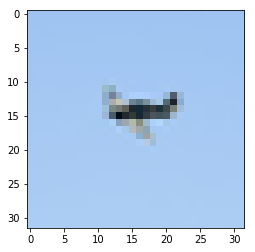

In [18]:
# Firstly, we create the placeholder that will receive the test data
x = tf.placeholder(tf.float32, [1, 32, 32, 3])
x_acc = tf.placeholder(tf.float32, [None, 32, 32, 3])


# Since we used a dictionary instead of a list for storing the parameters, but the training routine returns
# a list, we first convert manually the list into a dictionary
update_params = {}
list_of_keys = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5','b5']
update_params = {key : best_model[i] for i,key in enumerate(list_of_keys)}


# We then, call the fordward function
scores = five_layer_CNN(x=x, params=update_params, classes=10 ,training=False)
scores_acc = five_layer_CNN(x=x_acc, params=update_params, classes=10 ,training=False)

idx = np.random.randint(10000)

# Let's now create run the prediction graph
with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    scores2 = sess2.run(scores, feed_dict={x:x_test[idx].reshape(1, 32, 32, 3)})
    
    acc = compute_accuracy(sess2, 64, scores_acc, x_acc)
    
    print('Accuracy is: ', acc)
    
    print('The predicted class is: ', classes[np.argmax(scores2)])
    print('The correct class is: ', classes[y_test[idx]])
    
    plt.imshow(x_test[idx].astype(np.int32))
    


INFO:tensorflow:Restoring parameters from checkpoint_file
The predited class is:  Automobile
The correct class is:  Automobile


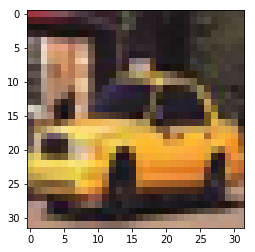

In [17]:
with tf.Session() as sess2:
    # Load saved Model
    saver = tf.train.import_meta_graph('checkpoint_file.meta')
    saver.restore(sess2, 'checkpoint_file')
    
    # Load saved points
    # Scores includes the complete model, with final parameters
    scores = tf.get_collection('scores')[0]
    # Saved placeholders, since we only want to run the inference graph, we only load x
    x = tf.get_collection('images')[0]
    
    # Variables to Test the accuracy is the best model's one and not just the last one
    x_acc = tf.placeholder(tf.float32, [None, 32, 32, 3])
    
    # Choose radom point in test data
    idx = np.random.randint(10000)
    plt.imshow(x_test[idx].astype(np.int32))
    
    # Calculate the score
    scores2 = sess2.run(scores, feed_dict={x:x_test[idx].reshape(1, 32, 32, 3)})
    
           
    print('The predited class is: ', classes[np.argmax(scores2)])
    print('The correct class is: ', classes[y_test[idx]])
